In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# YMT5270 Final Sınav Projesi: H2O ile Veri Analizi ve Makine Öğrenmesi

## 👩‍🎓 Öğrenci Bilgileri
# Ad Soyad: Yonca Ray
# Öğrenci Numarası: 241137128
# E-posta: rayyonca@gmail.com

In [ ]:
# Proje Özeti
"""
Proje Adı: EEG Eye State Sınıflandırması
Veri Seti: [EEG Eye State Data Set - UCI](https://archive.ics.uci.edu/dataset/264/eeg+eye+state)
Amaç: EEG verileri ile bireylerin göz durumunun (açık/kapalı) sınıflandırılması
Yöntem: H2O.ai AutoML kullanılarak sınıflandırma modeli oluşturulması

Tüm veriler Emotiv EEG Neuroheadset ile yapılan tek bir sürekli EEG ölçümünden alınmıştır.
Ölçümün süresi 117 saniyedir. Göz durumu EEG ölçümü sırasında bir kamera aracılığıyla
tespit edilmiş ve daha sonra video kareleri analiz edildikten sonra dosyaya manuel olarak
eklenmiştir. '1' gözün kapalı, '0' ise gözün açık durumunu belirtir. Tüm değerler, ilk
ölçülen değerin verilerin en üstünde olduğu kronolojik sıradadır.
"""

In [28]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [29]:
# H2O kurulumu
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,18 mins 15 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,2 months and 29 days
H2O_cluster_name:,H2O_from_python_unknownUser_zzzl9w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.052 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [31]:
# Veri Setini Yükle
df = pd.read_csv("/content/drive/MyDrive/datasets/eeg_eye_state.csv")

#  Keşifsel Veri Analizi (EDA)

In [ ]:
"""
- Veri seti 14 EEG kanalı + 1 hedef değişken (eyeDetection) içermektedir.
- Toplamda 14.980 örnek bulunmaktadır.
- Eksik veri bulunmamaktadır.
- Z-skor yöntemi ile aykırı değer analizi yapılmıştır ve aykırı değerler verisetinden çıkarılmıştır. (61 aykırı değer)
- Korelasyon matrisi, bazı EEG kanalları arasında orta düzeyde korelasyon olduğunu göstermektedir.
- Hedef değişken yaklaşık dengeli dağılmıştır (%55 göz açık, %45 göz kapalı).
- Veriler zaman serisi olarak toplanmış olmasına rağmen bu aşamada zaman bağımlılığı dikkate alınmamıştır.
"""

In [32]:
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [33]:
df.tail()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,1
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,1
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,1
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,1
14979,4287.69,3997.44,4260.00,4121.03,4333.33,4616.41,4088.72,4638.46,4212.31,4226.67,4167.69,4274.36,4597.95,4350.77,1


In [34]:
df.shape

(14980, 15)

In [35]:
df.columns

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4', 'eyeDetection'],
      dtype='object')

In [36]:
df["eyeDetection"].value_counts()

,count
eyeDetection,
0,8257
1,6723


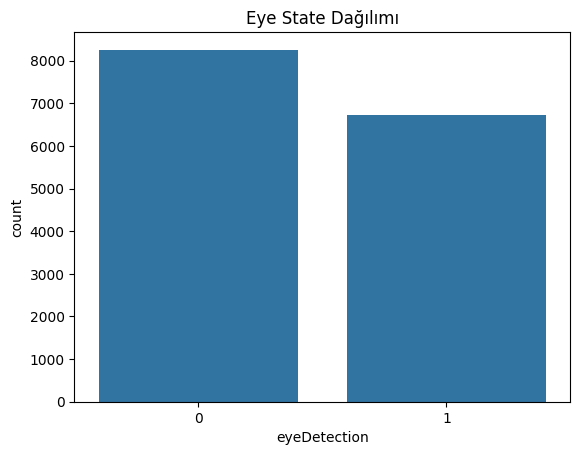

In [37]:
sns.countplot(x='eyeDetection', data=df)
plt.title("Eye State Dağılımı")
plt.show()

In [38]:
df.isnull().sum()

,0
AF3,0
F7,0
F3,0
FC5,0
T7,0
P7,0
O1,0
O2,0
P8,0
T8,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AF3,14980.0,4321.917777,2492.072174,1030.7700,4280.51,4294.36,4311.79,309231.00
F7,14980.0,4009.767694,45.941672,2830.7700,3990.77,4005.64,4023.08,7804.62
F3,14980.0,4264.022433,44.428052,1040.0000,4250.26,4262.56,4270.77,6880.51
FC5,14980.0,4164.946326,5216.404632,2453.3300,4108.21,4120.51,4132.31,642564.00
T7,14980.0,4341.741075,34.738821,2089.7400,4331.79,4338.97,4347.18,6474.36
P7,14980.0,4644.022379,2924.789537,2768.2100,4611.79,4617.95,4626.67,362564.00
O1,14980.0,4110.400160,4600.926543,2086.1500,4057.95,4070.26,4083.59,567179.00
O2,14980.0,4616.056904,29.292603,4567.1800,4604.62,4613.33,4624.10,7264.10
P8,14980.0,4218.826610,2136.408523,1357.9500,4190.77,4199.49,4209.23,265641.00
T8,14980.0,4231.316200,38.050903,1816.4100,4220.51,4229.23,4239.49,6674.36


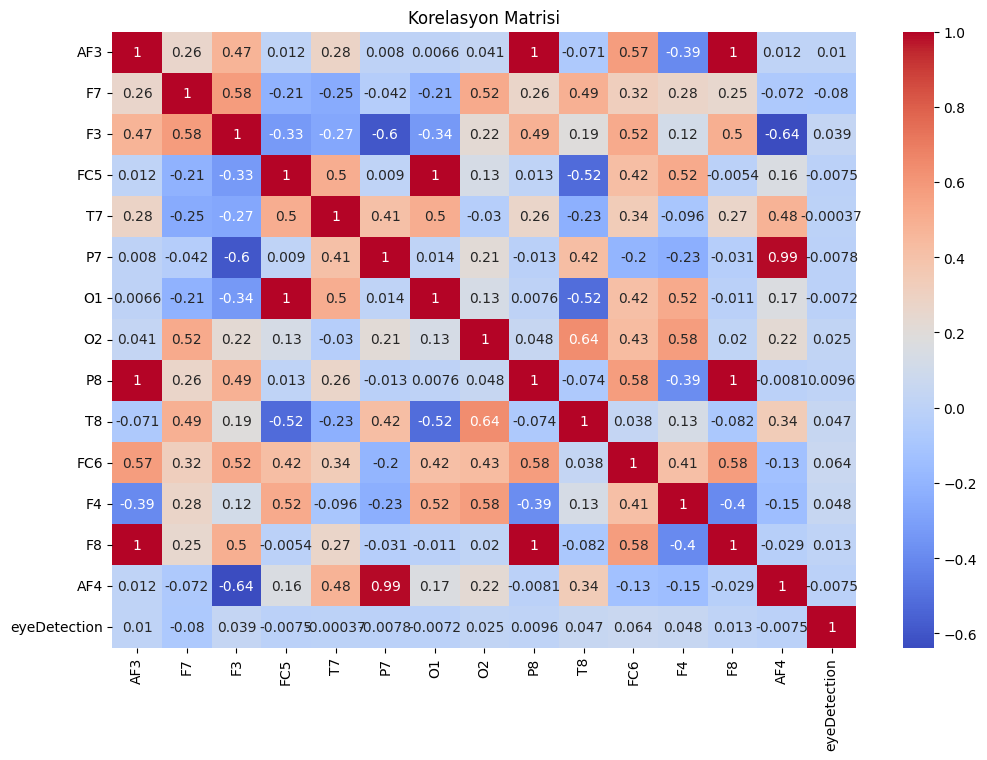

In [42]:
# Korelasyon matrisi
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Korelasyon Matrisi")
plt.show()

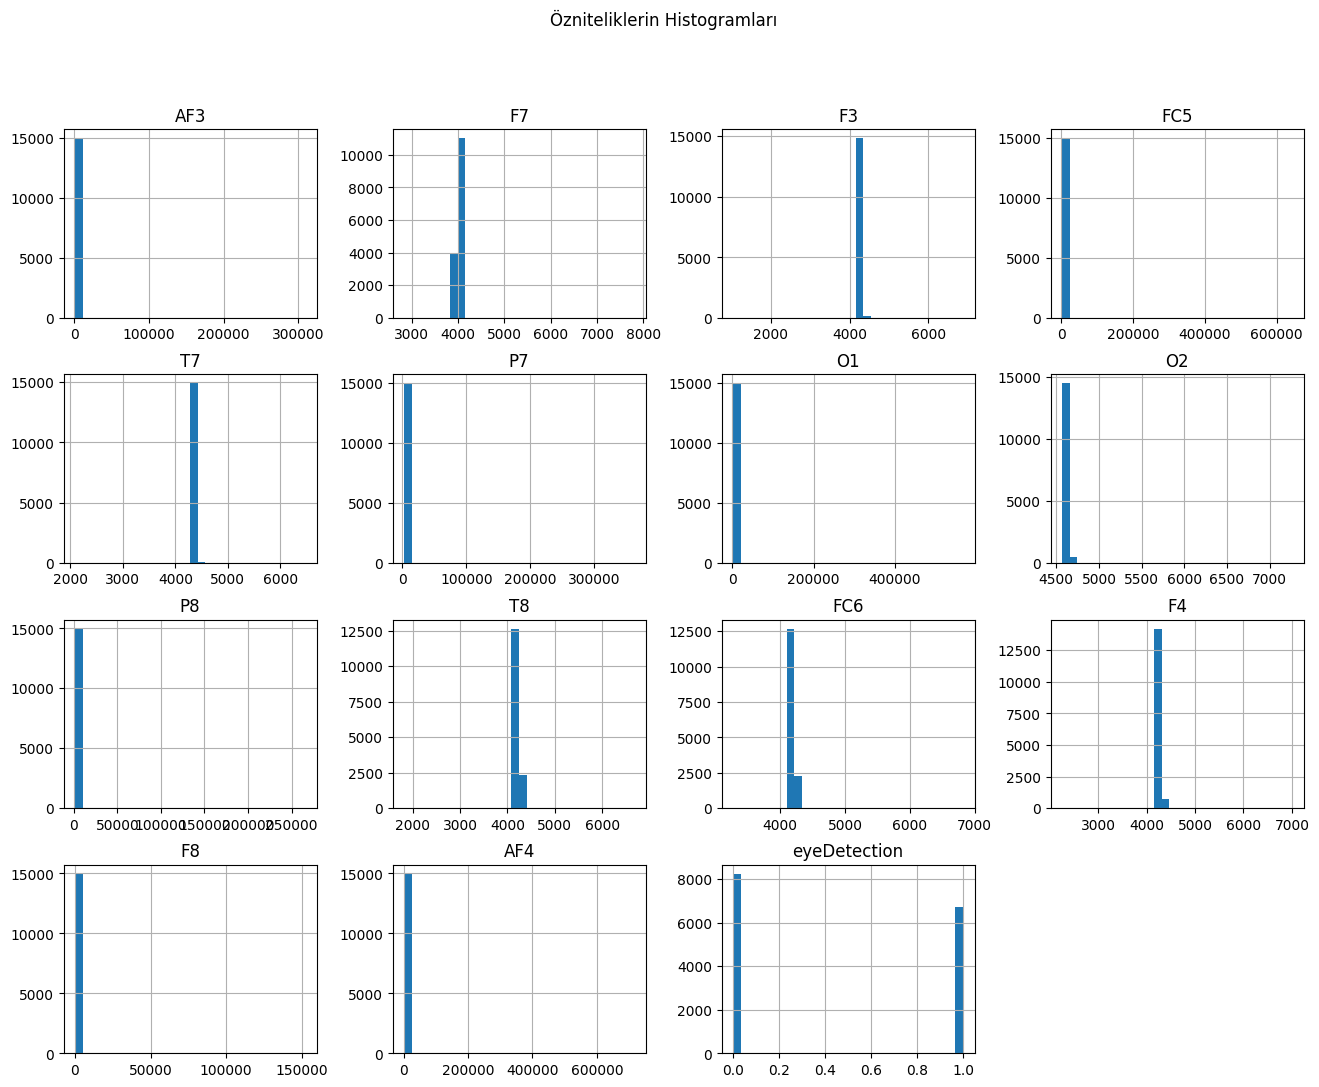

In [43]:
df.hist(figsize=(16, 12), bins=30)
plt.suptitle("Özniteliklerin Histogramları")
plt.show()

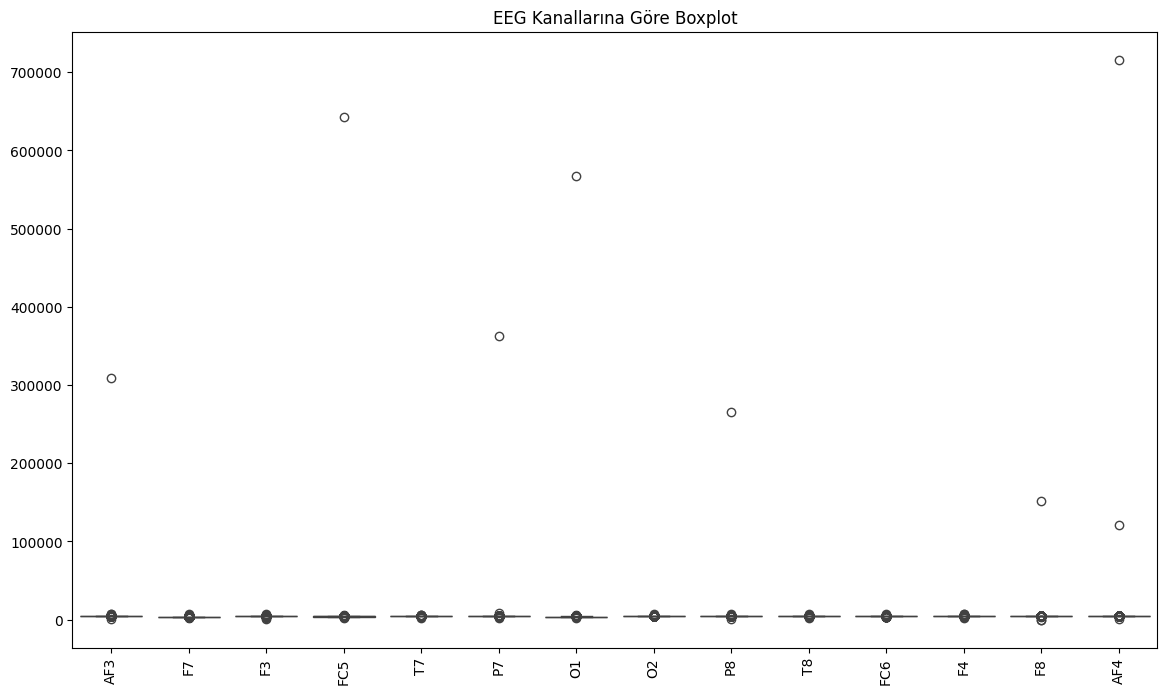

In [52]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df.iloc[:, :-1])
plt.xticks(rotation=90)
plt.title("EEG Kanallarına Göre Boxplot")
plt.show()

# Veri Önişleme

In [45]:
# Aykırı Değerlerin Tespiti ve Temizleme
z_scores = np.abs(zscore(df.iloc[:, :-1]))
outliers = (z_scores > 3.2).any(axis=1)
df_clean = df[~outliers]
print(f"Aykırı satır sayısı: {outliers.sum()}")

Aykırı satır sayısı: 61


In [46]:
# Veriyi H2O'ya Aktar ve Hazırla
hf = h2o.H2OFrame(df_clean)
target = 'eyeDetection'
features = [col for col in hf.columns if col != target]
hf[target] = hf[target].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [47]:
# Eğitim ve Test Verisine Ayır
train, test = hf.split_frame(ratios=[0.8], seed=42)

# Model Eğitimi

In [48]:
# H2O AutoML ile Model Eğitimi
aml = H2OAutoML(max_models=10, seed=42, balance_classes=True)
aml.train(x=features, y=target, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/10
# GBM base models (used / total),4/4
# XGBoost base models (used / total),0/3
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


# Değerlendirme ve Yorumlama

In [ ]:
"""
- H2O AutoML ile 10 farklı model eğitildi ve en iyi model otomatik olarak seçildi.
- En iyi model: `StackedEnsemble_AllModels`, AUC skoru 0.992 ile oldukça başarılıdır.
- Confusion matrix sonuçlarına göre genel hata oranı %3.74’tür:

- Maksimum F1 skoru %95.9 ile oldukça yüksektir.
- RMSE: 0.1746, LogLoss: 0.1062, AUCPR: 0.9917, Gini: 0.9859 değerleri doğruluk ve denge açısından tatmin edicidir.

Gelecek Öneriler:
- Zaman serisi öznitelikleri ile modele zaman bağımlılık eklenebilir.
- Derin öğrenme modelleri (LSTM, CNN gibi) H2O dışında karşılaştırmalı olarak denenebilir.
- Özellik seçimi (feature selection) uygulanarak daha az girdiyle benzer performans korunabilir.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_AllModels_1_AutoML_2_20250625_194732     0.992328   0.110626  0.991227               0.0428389  0.179511  0.0322243
GBM_4_AutoML_2_20250625_194732                           0.991928   0.115279  0.990844               0.0450378  0.18278   0.0334084
StackedEnsemble_BestOfFamily_1_AutoML_2_20250625_194732  0.991927   0.113303  0.990824               0.0448823  0.181503  0.0329433
GBM_3_AutoML_2_20250625_194732                           0.991117   0.121992  0.989803               0.0483794  0.189718  0.0359931
GBM_2_AutoML_2_20250625_194732                           0.990539   0.125442  0.989093               0.0473324  0.190723  0.0363751
GBM_1_AutoML_2_20250625_194732                           0.989519   0.132673  0.987968               0.0505     0.196742  0.0387074
XGBoost_3_AutoML_2_20250625_194732                       0.983884   0.162776  0.9816                 0.0641507  0.219104  0.0480068
XGBoost_2_AutoML_2_20250625_194732                       0.981498   0.172232  0.978911               0.0687053  0.224512  0.0504055
XRT_1_AutoML_2_20250625_194732                           0.981248   0.267431  0.97894                0.0742021  0.271531  0.0737291
DRF_1_AutoML_2_20250625_194732                           0.980632   0.26459   0.978439               0.0736771  0.270596  0.0732222

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4596724401161145
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1542  53    0.0332   (53.0/1595.0)
1      57    1289  0.0423   (57.0/1346.0)
Total  1599  1342  0.0374   (110.0/2941.0)
"""

In [49]:
# En İyi Model ve Performans
lb = aml.leaderboard
print(lb.head())

best_model = aml.leader
perf = best_model.model_performance(test_data=test)
print(perf)

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_AllModels_1_AutoML_2_20250625_194732     0.992328   0.110626  0.991227               0.0428389  0.179511  0.0322243
GBM_4_AutoML_2_20250625_194732                           0.991928   0.115279  0.990844               0.0450378  0.18278   0.0334084
StackedEnsemble_BestOfFamily_1_AutoML_2_20250625_194732  0.991927   0.113303  0.990824               0.0448823  0.181503  0.0329433
GBM_3_AutoML_2_20250625_194732                           0.991117   0.121992  0.989803               0.0483794  0.189718  0.0359931
GBM_2_AutoML_2_20250625_194732                           0.990539   0.125442  0.989093               0.0473324  0.190723  0.0363751
GBM_1_AutoML_2_20250625_194732                           0.989519   0.132673  0.987968               0.0505     0.196742  0.0387074
XGBoost_3_AutoML_2_20250625_194732                       0.983884   0.162776

In [50]:
# Confusion Matrix
y = perf.confusion_matrix()
print(y)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4596724401161145
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1542  53    0.0332   (53.0/1595.0)
1      57    1289  0.0423   (57.0/1346.0)
Total  1599  1342  0.0374   (110.0/2941.0)
